## NUSSIF (Systemic & Strategy) Case Study : Systematic Return Prediction for US Treasury ETFs (TLT) 

### Asset Selection & Motivation 

This study focuses on TLT, an exchange-traded fund (ETF) that tracks long-duration U.S. Treasury bonds, as a proxy for the U.S. long-term government bond market (BlackRock, 2019). Treasury bonds play a central role in global financial markets, serving as benchmarks for risk-free rates, monetary policy transmission, and risk-off asset allocation. As a long-duration bond ETF, TLT is particularly sensitive to changes in interest rate expectations, inflation dynamics, and macroeconomic risk sentiment (Investopedia, 2023).

While extensive research documents the difficulty of predicting asset returns due to semi-strong market efficiency, prior literature suggests that bond returns may exhibit time-varying predictability when conditioned on macroeconomic variables and policy regimes (Procedia Economics and Finance, 2015). Motivated by this, the objective of this project is not to identify strong point forecasts, but to examine whether economically motivated macro and market-based features can improve the risk-adjusted performance of systematic trading strategies in U.S. Treasuries.

The analysis is conducted at a weekly frequency as weekly aggregation reduces high-frequency noise and better reflects the pace at which macroeconomic information is incorporated into bond prices. Using TLT weekly returns as the outcome variable, the study evaluates a systematic return-prediction framework through disciplined feature construction, backtesting, and performance evaluation.

### Outcome Construction 
#### Imports & Setup 



In [1]:
!pip -q install yfinance pandas   # install yfinance

In [2]:
import yfinance as yf 
import pandas as pd

#### Download TLT Daily Price Data (yfinance)

In [3]:
ticker = "TLT"
start_date = "2002-01-01"   # earliest practical start for TLT
end_date = None             # get up to latest available data 

df = yf.download(
    ticker,
    start=start_date,
    end=end_date,
    interval="1d",
    auto_adjust=False,      # keep Adj Close (price adjusted for dividends & splits) separate from raw prices 
    actions=True,           # includes dividends & splits columns
    progress=False         
)

df.head()                   # show daily data 

Price,Adj Close,Capital Gains,Close,Dividends,High,Low,Open,Stock Splits,Volume
Ticker,TLT,TLT,TLT,TLT,TLT,TLT,TLT,TLT,TLT
Date,,,,,,,,,
2002-07-30,36.648289,0.0,81.519997,0.0,81.900002,81.519997,81.750000,0.0,6100
2002-07-31,37.102360,0.0,82.529999,0.0,82.800003,81.900002,81.949997,0.0,29400
2002-08-01,37.313648,0.0,83.000000,0.0,83.019997,82.540001,82.540001,0.0,25000
2002-08-02,37.695770,0.0,83.849998,0.0,84.099998,82.879997,83.160004,0.0,52800
2002-08-05,37.862114,0.0,84.220001,0.0,84.440002,83.849998,84.040001,0.0,61100


#### Data Cleaning & Preprocessing

In [4]:
df = df.sort_index()     # sort by index (dates) to ensure valid time-operations and prevent look-ahead bias
df = df[~df.index.duplicated(keep="first")]     # remove duplicate if any 
df.columns = df.columns.get_level_values(0)     # convert multiIndex to single level columns

#### Frequency Transformation: Daily to Weekly 

In [5]:
weekly_price = df["Adj Close"].resample("W-FRI").last().dropna() # group data by week, with each week ending on Friday, 
                                                                 # using last available price  

#### Weekly Return & Next Week Return (outcome) Construction

In [6]:
weekly_price = df["Adj Close"].resample("W-FRI").last().dropna() # group data by week, with each week ending on Friday using last available price  

weekly_df = pd.DataFrame({
    "Adj Close": weekly_price,
    "Return": weekly_price.pct_change(),                   # compute percentage returns 
    "Return Next Wk": weekly_price.pct_change().shift(-1)  # Outcome variable (predict t+1 using features at t)
}).dropna()

weekly_df.head()

,Adj Close,Return,Return Next Wk
Date,,,
2002-08-09,38.158810,0.012284,0.002121
2002-08-16,38.239742,0.002121,0.009875
2002-08-23,38.617374,0.009875,0.013737
2002-08-30,39.147865,0.013737,0.008684
2002-09-06,39.487843,0.008684,0.015093


In [7]:
print(weekly_df.index.min(), "to", weekly_df.index.max())   # period of weekly data obtained
print("Rows:", len(weekly_df))                              # number of weekly data rows obtained
print(weekly_df.columns)

2002-08-09 00:00:00 to 2025-12-19 00:00:00
Rows: 1220
Index(['Adj Close', 'Return', 'Return Next Wk'], dtype='object')


In [8]:
weekly_df = weekly_df.sort_index()                                  # sort by index (dates)  
weekly_df = weekly_df[~weekly_df.index.duplicated(keep="first")]    # remove duplicate if any 
weekly_df.index = pd.to_datetime(weekly_df.index)                   # ensure index is datetime
weekly_df = weekly_df.dropna(subset=["Adj Close", "Return"])        # drop rows with missing values

In [9]:
weekly_df.to_csv("TLT_weekly_2002_present.csv")    #export to csv 

### Macro Features Construction
#### Imports & Setup

In [10]:
!pip install yfinance pandas_datareader

In [11]:
import numpy as np
from pandas_datareader import data as pdr

#### Download Macroeconomic Data (FRED)

In [18]:
start = "2010-01-01"
end = None

fred_series = {
    "CPI": "CPIAUCSL",              # inflation rate 
    "FEDFUNDS": "FEDFUNDS",         # interest rate (policy stance) 
    "SLOPE_10Y2Y": "T10Y2Y",        # yield curve slope (cycle / recession risk) 
    "INDPRO": "INDPRO",             # industrial production (real economic activity) 
    "BEI_10Y": "T10YIE",            # 10-year breakeven inflation rate (inflation expectations over next 10 years) 
    "DGS10": "DGS10",               # 10-year treasury yield (benchmark LT interest rate) 
    "DGS2": "DGS2",                 # 2-year treasury yield (benchmark short-to-medium term interest rate) 
    "VIX": "VIXCLS"                 # CBOE Volatility Index (market fear & uncertainty) 
}

fred_list = []
for name, code in fred_series.items():
    s = pdr.DataReader(code, "fred", start, end)   # returns a DataFrame with column = code
    s = s.rename(columns={code: name})             # rename column
    fred_list.append(s)

fred = pd.concat(fred_list, axis=1)                # combines all the macro series into one DataFrame

fred.head()

,CPI,FEDFUNDS,SLOPE_10Y2Y,INDPRO,BEI_10Y,DGS10,DGS2,VIX
DATE,,,,,,,,
2010-01-01,217.488,0.11,NaN,89.3426,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,2.76,NaN,2.38,3.85,1.09,20.04
2010-01-05,NaN,NaN,2.76,NaN,2.34,3.77,1.01,19.35
2010-01-06,NaN,NaN,2.84,NaN,2.37,3.85,1.01,19.16
2010-01-07,NaN,NaN,2.82,NaN,2.41,3.85,1.03,19.06


#### Frequency Transformation to Weekly

In [19]:
fred_w = fred.resample("W-FRI").ffill()

#### Data Transformation into Meaningful Measures

In [20]:
fred_w["CPI_yoy"] = fred_w["CPI"].pct_change(52) * 100           # YoY inflation (%) by comparing CPI 52 weeks ago
fred_w["FEDFUNDS_chg"] = fred_w["FEDFUNDS"].diff()               # weekly change in policy/interest rate (policy shocks) 
fred_w["DGS10_chg"] = fred_w["DGS10"].diff()                     # weekly change in 10Y yield (rate shocks) 
fred_w["DGS2_chg"] = fred_w["DGS2"].diff()                       # weekly change in 2Y yield
fred_w["BEI_10Y_chg"] = fred_w["BEI_10Y"].diff()                 # weekly change in breakeven inflation
fred_w["INDPRO_yoy"] = fred_w["INDPRO"].pct_change(52) * 100     # YoY industrial production (%)
fred_w["VIX_chg"] = fred_w["VIX"].diff()                         # weekly change in market fear 

/var/folders/mc/d9mx3nks2vd_f_fbf4k8k5qh0000gn/T/ipykernel_982/1504423056.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fred_w["CPI_yoy"] = fred_w["CPI"].pct_change(52) * 100           # YoY inflation (%) by comparing CPI 52 weeks ago
/var/folders/mc/d9mx3nks2vd_f_fbf4k8k5qh0000gn/T/ipykernel_982/1504423056.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fred_w["INDPRO_yoy"] = fred_w["INDPRO"].pct_change(52) * 100     # YoY industrial production (%)


### Market-based Features Construction
#### Market Sentiment Proxy (SPY) -> weekly S&P 500 return (market risk-on/off proxy)

In [21]:
spy_daily = yf.download("SPY", start=start, auto_adjust=True, progress=False)   # download daily data 

if isinstance(spy_daily.columns, pd.MultiIndex):        
    spy_daily.columns = spy_daily.columns.get_level_values(0)                   # flatten columns if yfinance returns MultiIndex (safe even if not)

close = spy_daily["Close"]
if isinstance(close, pd.DataFrame):                                             # rare edge case
    close = close.iloc[:, 0]

spy_w_px = close.resample("W-FRI").last().dropna()                              # transform data frequency from daily to weekly
spy_w_ret = spy_w_px.pct_change().dropna()                                      # compute weekly returns 

market = spy_w_ret.to_frame(name = "SPY_ret")
market.head()

,SPY_ret
Date,
2010-01-15,-0.008117
2010-01-22,-0.038983
2010-01-29,-0.016665
2010-02-05,-0.006798
2010-02-12,0.012938


### TLT Technical/Behaviour Features
#### TLT Momentum -> measure trend-like behaviour

In [22]:
weekly_df["mom_4w"] = weekly_df["Adj Close"].pct_change(4)       # % change over past 4 weeks (ST)
weekly_df["mom_12w"] = weekly_df["Adj Close"].pct_change(12)     # % change over past 12 weeks (LT)

#### TLT Realized Volatility -> measure risk/uncertainty 

In [23]:
weekly_df["vol_12w"] = weekly_df["Return"].rolling(12).std()     # compute std deviation of weekly TLT returns within last 12 weeks 

### Features Selection

Given small sample size and the presence of many highly correlated predictors, using all predictors inflates variance and obscures economic interpretation. Hence, predictors are selected based on their economic relevance to long-duration Treasury pricing, interpretability and statistical robustness. Rather than including all available variables, the model employs a parsimonious subset capturing inflation, growth, monetary policy, yield dynamics, and risk sentiment. 

Regime variables (CPI_yoy, INDPRO_yoy, SLOPE_10Y2Y) are included to capture **slow-moving macroeconomic states**. **Year-on-year inflation** and **industrial production growth** reflect persistent inflationary and growth regimes that **influence real interest rates and safe-asset demand**, while the **yield curve slope** summarises **expectations about future economic activity and recession risk**. These variables are preferred over high-frequency macro releases or raw levels because they are economically interpretable and less noisy, making them suitable for medium-term (weekly) return prediction.

Interest-rate dynamics are captured through **changes in the 10-year Treasury yield** (DGS10_chg) and the **level of the 2-year yield** (DGS2). Long-duration bond returns are mechanically sensitive to **movements in long-term yields**, while the 2-year yield reflects **market expectations of future monetary policy**. This combination captures both **rate shocks and policy expectations** without relying on infrequently changing policy rates, thereby improving data coverage and stability.

Expectation-based variables are represented by **changes in 10-year breakeven inflation** (BEI_10Y_chg), which capture forward-looking **inflation expectations** rather than realised inflation. Breakevens often adjust more rapidly to new information than headline CPI and therefore provide complementary information about real rate expectations that is particularly relevant for long-maturity bonds.

Risk sentiment variables (VIX_chg, SPY_ret) are included to account for cross-asset dynamics and flight-to-safety behaviour. **Sudden increases in market uncertainty** and **equity drawdowns** are historically associated with **increased demand for Treasuries**. **Changes in the VIX** capture **shocks to risk aversion**, while **equity market returns** provide a direct measure of **risk-on versus risk-off conditions**. These variables are preferred over additional volatility or sentiment indicators to avoid redundancy.

Finally, market behaviour variables (mom_12w, vol_12w) are included to capture time-varying risk premia and persistence in bond market behaviour. **Medium-term momentum** reflects **gradual adjustments to macro regimes**, while **realised volatility** proxies for **uncertainty in the rate environment**. Shorter-horizon technical indicators are excluded to maintain alignment with the medium-term focus of the study.

Additional variables are reserved for robustness checks rather than inclusion in the model, ensuring that model performance reflects genuine economic signal rather than overfitting. Predictors are also lagged by one week to ensure all information is available at decision time.

In [24]:
X = pd.concat([fred_w, market], axis=1)     # combine macro and market-based variable

predictors = [
    "CPI_yoy", "INDPRO_yoy", "SLOPE_10Y2Y", "DGS10_chg", "DGS2", "BEI_10Y_chg", "VIX_chg", "SPY_ret",    # 10 chosen predictors
]

X = X[predictors].shift(1)                  # shifts all predictors down by one week 

### Merge into one Modelling Dataset

In [25]:
model_df = weekly_df.join(X, how="inner")

keep_cols = ["Return Next Wk", "Return", "mom_12w", "vol_12w"] + predictors
model_df = model_df[keep_cols].dropna()

model_df.head()

,Return Next Wk,Return,mom_12w,vol_12w,CPI_yoy,INDPRO_yoy,SLOPE_10Y2Y,DGS10_chg,DGS2,BEI_10Y_chg,VIX_chg,SPY_ret
2011-01-14,-0.003484,-0.005522,-0.084941,0.012943,0.711304,3.747037,2.74,0.04,0.60,0.06,-0.61,0.011054
2011-01-21,0.004370,-0.003484,-0.079411,0.012967,0.711304,3.747037,2.76,0.01,0.59,-0.01,-1.68,0.016989
2011-01-28,-0.030432,0.004370,-0.055374,0.012477,0.711304,3.747037,2.81,0.09,0.63,-0.11,3.01,-0.007192
2011-02-04,0.007318,-0.030432,-0.063376,0.013702,0.711304,3.747037,2.82,-0.08,0.54,0.03,1.57,-0.005063
2011-02-11,0.000336,0.007318,-0.064140,0.013630,0.711304,3.747037,2.91,0.32,0.77,0.11,-4.11,0.026855


### Exploratory Data Analysis 
#### Distribution of Weekly TLT Returns

<Axes: >

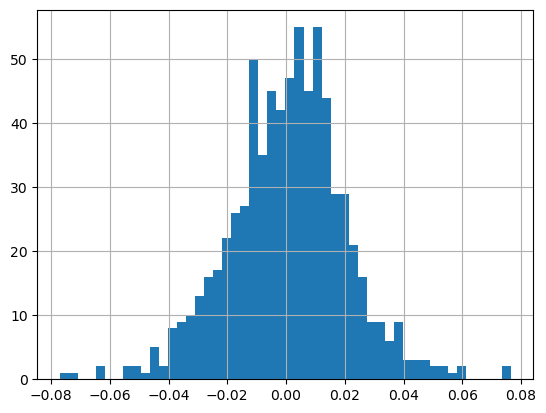

In [26]:
model_df["Return Next Wk"].hist(bins=50)

The distribution of weekly TLT returns is **centred close to zero** and exhibits a roughly **symmetric** shape with noticeable tail observations on both sides. This highlights that the average weekly returns are **small relative to volatility**, **consistent with semi-strong market efficiency**, and that extreme positive and negative returns occur relatively **infrequently** but are non-negligible, reflecting sensitivity to macroeconomic shocks such as changes in inflation expectations or monetary policy surprises. The presence of fat tails reinforces the view that return predictability, if present, is likely to be weak and regime-dependent rather than persistent and linear.

#### Time Series of TLT Returns and Yield Curve Slope

array([<Axes: >, <Axes: >], dtype=object)

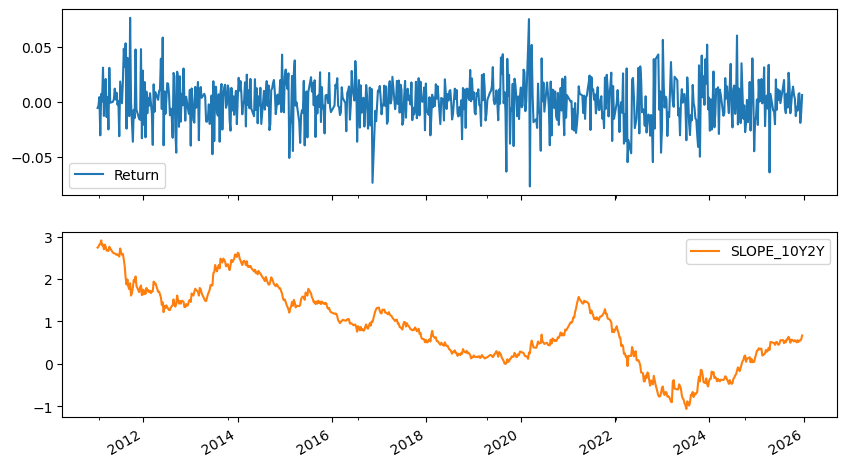

In [27]:
model_df[["Return", "SLOPE_10Y2Y"]].plot(subplots=True, figsize=(10,6))

The time-series plots illustrate that weekly TLT returns are **highly volatile** and **fluctuate around zero**, while the yield curve slope evolves **slowly** over time, reflecting changes in the macroeconomic and policy environment. Periods of curve flattening and inversion are visually associated with distinct return regimes, particularly around major macroeconomic episodes such as **recessions** and **tightening cycles**. 

#### Scatter Plot for 10-Year Yield Changes and Next-Week TLT Returns

<Axes: xlabel='DGS10_chg', ylabel='Return Next Wk'>

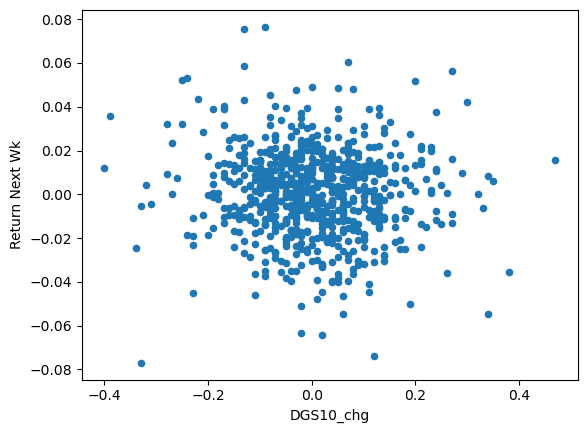

In [28]:
model_df.plot.scatter(x="DGS10_chg", y="Return Next Wk")

The scatter plot of next-week TLT returns against weekly changes in the 10-year Treasury yield reveals that **large increases** in yields are generally associated with **negative TLT returns**, reflecting the mechanical inverse relationship between bond prices and yields. However, the dispersion of points is **substantial**, indicating that yield changes alone explain only a small fraction of return variation. This underscores the difficulty of return prediction and supports the use of a multi-factor framework that combines rate dynamics with macroeconomic regimes and risk sentiment indicators.

### Train/test Split based on Time-Series

In [29]:
split_date = "2020-01-01"

y = model_df["Return Next Wk"]
features = predictors + ["Return", "mom_12w", "vol_12w"]
X_base = model_df[features]

X_train = X_base.loc[:split_date]     # training sample 
y_train = y.loc[:split_date]

X_test = X_base.loc[split_date:]      # test sample 
y_test = y.loc[split_date:]

print("Training period:", X_train.index.min(), "to", X_train.index.max())
print("Test period:", X_test.index.min(), "to", X_test.index.max())

print("Training observations:", len(X_train))
print("Test observations:", len(X_test))
print("Total observations:", len(X_base))

print(f"Training share: {len(X_train) / len(X_base):.1%}")
print(f"Test share: {len(X_test) / len(X_base):.1%}")

Training period: 2011-01-14 00:00:00 to 2019-12-27 00:00:00
Test period: 2020-01-03 00:00:00 to 2025-12-19 00:00:00
Training observations: 439
Test observations: 289
Total observations: 728
Training share: 60.3%
Test share: 39.7%


The dataset is split chronologically at **January 2020**, with observations from January 2011 to December 2019 used for model estimation and observations from January 2020 onward reserved for out-of-sample evaluation, resulting in a approximately **60/40 train-test split**. This **time-based split** preserves the temporal ordering of the data and avoids look-ahead bias, ensuring that model performance reflects a realistic investment setting. 

In particular, the out-of-sample period encompasses the COVID-19 shock, the subsequent inflation surge, and an aggressive monetary tightening cycle, providing a stringent and economically meaningful test of model robustness. This split therefore balances the need for stable model estimation with the objective of evaluating performance under challenging and diverse market conditions.

### Modelling + Out-of-Sample Prediction
#### Baseline Model (OLS - Linear Regression) 

In [30]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)     # fit the model 

y_pred_ols = pd.Series(lr.predict(X_test), index=X_test.index, name="pred_ols")     # predict next-week TLT returns on test set 

#### Main Model (Ridge Regression) 

In [31]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-4, 4, 50))     # model automatically selects an appropriate degree of shrinkage, 
                                                   # reducing overfitting while preserving economically meaningful signals

ridge.fit(X_train, y_train)                        # fit the model

y_pred_ridge = pd.Series(ridge.predict(X_test), index=X_test.index, name="pred_ridge")   # predict next-week TLT returns on test set 

### ADD WHY RIDGE REGRESSION HERE 

### Converting Predictions into Trading Signals

In [32]:
sig_ols = (y_pred_ols > 0).astype(int)
sig_ridge = (y_pred_ridge > 0).astype(int)

Predicted next-week returns are converted into a **binary trading signal** using a simple **long/flat rule**. For each week, the signal takes a value of **one** when the model forecasts a **positive return** and zero otherwise, indicating whether the strategy **holds exposure to TLT** or **remains in cash**. This transformation focuses on the **direction** of the forecast rather than its magnitude due to the high level of noise inherent in short-horizon return predictions. By requiring positive expected returns before taking risk, the signal construction introduces an implicit confidence filter that **reduces unnecessary trading** and **limits exposure during unfavourable or uncertain conditions**. This conservative rule is deliberately chosen to prioritise robustness and risk control over **aggressive return targeting**.

### Computing Out-of-Sample Strategy Returns 

In [33]:
y_test = pd.Series(y_test, index=X_test.index, name="Return Next Wk")     # to ensure y_test is a pandas Series with the same date index as X_test

ret_ols = sig_ols * y_test          # Long/Flat strategy returns
ret_ridge = sig_ridge * y_test      
 
ret_bh = 1 * y_test                 # static buy-and-hold benchmark

Strategy returns are then computed by applying the long/flat trading signals to the **realised returns**, such that the strategy earns the **asset return** when a **long** position is taken and earns **zero** when the model indicates **no exposure**. This implementation directly maps model forecasts into **investable outcomes** while preserving temporal consistency. For comparison, a **static buy-and-hold benchmark** is constructed by maintaining **passive constant exposure** to TLT throughout the test period without any market-timing or risk-management. Evaluating model-based strategies relative to this benchmark allows the incremental contribution of macro-conditioned signals to risk-adjusted performance to be assessed in a transparent and economically meaningful manner.

Instead of trying to forecast TLT returns perfectly, the project evaluates whether adjusting positions based on the prevailing macroeconomic environment leads to more stable and efficient performance than a static approach.

### Performance Evaluation (Sharpe, annualised return/vol, max drawdown)


In [34]:
def perf_stats(r, freq=52):
    r = r.dropna()
    ann_ret = r.mean() * freq                                # avg annual return computed from avg weekly return 
    ann_vol = r.std() * np.sqrt(freq)                        # avg annual volatily computed from weekly return volatility (measures annual risk)  
    sharpe = np.nan if ann_vol == 0 else ann_ret / ann_vol   # Sharpe ratio (return per unit risk)  

    wealth = (1 + r).cumprod()        # transforms returns into cumulative wealth index (shows how $1 invested grows over time)                      
    peak = wealth.cummax()            
    dd = (wealth / peak) - 1
    max_dd = dd.min()                 # find largest peak-to-trough loss 

    return pd.Series({
        "Ann Return": ann_ret,
        "Ann Vol": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd,
        "Obs": len(r)
    })

results = pd.DataFrame({                        
    "Buy&Hold": perf_stats(ret_bh),
    "OLS Long/Flat": perf_stats(ret_ols),
    "Ridge Long/Flat": perf_stats(ret_ridge),
}).T

results

,Ann Return,Ann Vol,Sharpe,Max Drawdown,Obs
Buy&Hold,-0.033157,0.155265,-0.213553,-0.466493,289.0
OLS Long/Flat,0.017320,0.126770,0.136622,-0.300919,289.0
Ridge Long/Flat,-0.003995,0.128439,-0.031102,-0.300919,289.0


Strategy performance is evaluated using a common set of risk and return metrics, which includes annualised return, annualised volatility, Sharpe ratio, and maximum drawdown applied consistently across all strategies. Performances of model-based long/flat strategies (OLS and Ridge) are evaluated relative to the static buy-and-hold benchmark, allowing any differences in outcomes to be attributed to dynamic timing decisions rather than passive exposure to Treasury duration risk. 

The results indicate that **model-based long/flat strategies** materially **improve risk-adjusted performance** relative to buy-and-hold, even though absolute returns remain **modest**. This outcome is consistent with expectations under **semi-strong market efficiency**, where timing signals are more likely to contribute through **risk reduction** and **drawdown control** than through persistent excess returns. 

OLS strategy achieves lower volatility and substantially reduced drawdowns, resulting in a positive Sharpe ratio. The Ridge-based strategy further stabilises risk but exhibits weaker return performance, reflecting the trade-off between robustness and signal responsiveness. This outcome is consistent with expectations under **semi-strong market efficiency**, where timing signals are more likely to contribute through **risk reduction** and **drawdown control** than through persistent excess returns.

### Equity Curve Plot 

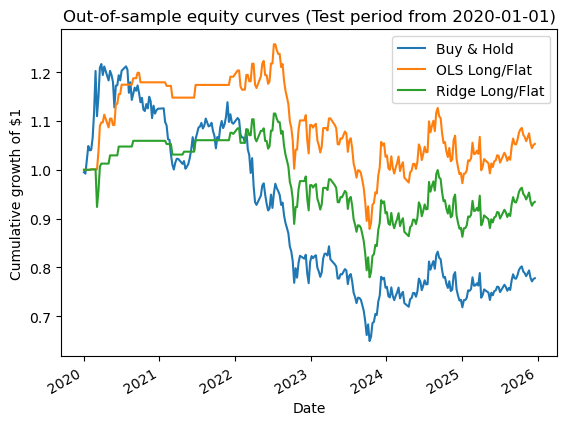

In [35]:
import matplotlib.pyplot as plt

equity = pd.DataFrame({
    "Buy & Hold": (1 + ret_bh).cumprod(), 
    "OLS Long/Flat": (1 + ret_ols).cumprod(),
    "Ridge Long/Flat": (1 + ret_ridge).cumprod(),
})

equity.plot()
plt.title("Out-of-sample equity curves (Test period from 2020-01-01)")
plt.xlabel("Date")
plt.ylabel("Cumulative growth of $1")
plt.show()

Equity curves are constructed by compounding weekly returns to illustrate the cumulative growth of one dollar invested under each strategy during the out-of-sample period (from 2020), a timeframe characterised by **macroeconomic shocks** and a **prolonged rise in interest rates**. 

The buy-and-hold strategy exhibits **substantial volatility** and a pronounced **drawdown**, particularly from 2021 onward, reflecting the adverse impact of rising yields on long-duration Treasuries. Despite intermittent recoveries, the benchmark fails to regain prior peaks, highlighting the cost of maintaining constant exposure during an unfavourable rate environment.

In contrast, the OLS long/flat strategy demonstrates **improved capital preservation**. While it experiences fluctuations, the equity curve has lesser deep and persistent drawdowns observed in the buy-and-hold benchmark and remains **consistently above** it for most of the test period (mid 2020 to end of 2025). This suggests that the model-based timing rule is effective at **reducing exposure** during periods of negative expected returns, resulting in **smoother performance and faster recoveries** after market stress.

The Ridge long/flat strategy exhibits an **intermediate** profile. Its equity curve is much **less volatile** than buy-and-hold (especially before 2022) and avoids extreme losses, but it **underperforms OLS** in terms of cumulative growth. 

Overall, the equity curves reinforce the conclusion that the primary contribution of the macro-conditioned strategies lies in **drawdown mitigation** and **volatility control** rather than aggressive return generation. The visual evidence aligns closely with the quantitative performance metrics, illustrating how dynamic exposure based on economic conditions can materially improve the investment experience during challenging macro regimes.

### Threshold to Reduce Churn (Robustness Extension) 

In [36]:
thr = 0.0005      # min predicted return threshold = 0.05% (5 bps weekly)
                  # model will only risk when forecast exceeds threshold level, filtering out weak or noist signals close to zero 

sig_ridge_thr = (y_pred_ridge > thr).astype(int)
ret_ridge_thr = sig_ridge_thr * y_test

perf_stats(ret_ridge_thr).to_frame("Ridge Long/Flat (threshold)")

,Ridge Long/Flat (threshold)
Ann Return,-0.014463
Ann Vol,0.127575
Sharpe,-0.113370
Max Drawdown,-0.304258
Obs,289.000000


As a robustness extension, a minimum return threshold is applied to the **Ridge model’s** forecasts to **reduce sensitivity to weak or noisy signals**. The strategy takes exposure only when the **predicted next-week return exceeds the small positive threshold**, remaining out of the market otherwise. This conservative filter is designed to limit unnecessary trading and improve signal quality rather than to optimise performance. 

The thresholded Ridge strategy delivers a negative annualised return of −1.4% with an annualised volatility of approximately 12.8%, resulting in a negative Sharpe ratio. While volatility and maximum drawdown are similar to the unthresholded Ridge strategy, the additional return filter reduces exposure during periods of weak predicted returns without materially improving risk-adjusted performance. In practice, the threshold appears to exclude some profitable opportunities alongside noisy signals, leading to **lower average returns without a commensurate reduction in risk**.

This outcome highlights the trade-off inherent in applying conservative thresholds to already regularised models. While such filters can improve robustness in some settings, in this case the combination of coefficient shrinkage and a return threshold likely results in **over-filtering**, dampening the strategy’s responsiveness to directional opportunities. The results therefore suggest that **simple long/flat implementation of the Ridge model without an additional threshold** strikes a more balanced trade-off between signal responsiveness and risk control.

### Model-based Variable Selection 

In [40]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

LassoCV(cv=5)

In [38]:
lasso_coef = pd.Series(
    lasso.coef_,
    index=X_train.columns,
    name="Lasso Coefficient"
).sort_values(key=abs, ascending=False)

In [39]:
selected_vars = lasso_coef[lasso_coef != 0]
dropped_vars = lasso_coef[lasso_coef == 0]

print("Selected variables:")
print(selected_vars)

print("\nDropped variables:")
print(dropped_vars.index.tolist())

Selected variables:
Return        -0.155834
SPY_ret       -0.042118
BEI_10Y_chg   -0.019584
mom_12w        0.010917
DGS10_chg     -0.005194
SLOPE_10Y2Y    0.005059
DGS2           0.004413
VIX_chg        0.000149
INDPRO_yoy    -0.000100
CPI_yoy       -0.000003
Name: Lasso Coefficient, dtype: float64

Dropped variables:
['vol_12w']


In [40]:
lasso_summary = pd.DataFrame({
    "Coefficient": lasso_coef,
    "Selected": lasso_coef != 0
})

lasso_summary

,Coefficient,Selected
Return,-0.155834,True
SPY_ret,-0.042118,True
BEI_10Y_chg,-0.019584,True
mom_12w,0.010917,True
DGS10_chg,-0.005194,True
SLOPE_10Y2Y,0.005059,True
DGS2,0.004413,True
VIX_chg,0.000149,True
INDPRO_yoy,-0.000100,True
CPI_yoy,-0.000003,True


Model-based variable selection is conducted using **Lasso regression** as a diagnostic **robustness check** rather than as a replacement for the baseline specification. Lasso applies an L1 regularisation penalty that **shrinks weak or redundant coefficients toward zero**. 

The results indicate that return predictability is diffuse rather than concentrated in a single factor, with non-zero coefficients assigned to variables capturing **interest rate dynamics** (DGS10_chg, DGS2, SLOPE_10Y2Y), **inflation expectations** (BEI_10Y_chg, CPI_yoy), and **broader risk conditions** (VIX_chg, SPY_ret). **Medium-term momentum** (mom_12w) is retained, while **short-horizon volatility** (vol_12w) is shrunk to zero, possibly suggesting that limited incremental information once macroeconomic and rate variables are accounted for.

### Concluding Remarks 


This study examines whether macroeconomic and market-based information can be used to improve the risk-adjusted performance of a long-duration Treasury ETF through systematic timing. Linear models are employed to forecast short-horizon returns and translate those forecasts into conservative long/flat investment strategies. While absolute return predictability remains limited, consistent with semi-strong market efficiency, the results indicate that model-based exposure control can materially reduce volatility and drawdowns relative to static buy-and-hold exposure during a prolonged period of rising interest rates.

Across model specifications, the OLS-based strategy achieves the most favourable balance between responsiveness and robustness, delivering smoother performance and improved risk-adjusted outcomes without reliance on complex modelling techniques. 

Several limitations should be acknowledged. First, transaction costs and slippage are not explicitly modelled. While the weekly trading frequency limits turnover, incorporating realistic implementation costs would provide a more conservative assessment of net performance. Second, model parameters are estimated using a fixed training window, and alternative approaches such as rolling or expanding-window estimation may better capture evolving macroeconomic relationships.

Future studies may consider regime-dependent models or non-linear specifications but any performance gains should be weighed against increased complexity and overfitting risk. 

Overall, the findings highlight that the primary contribution of macro-conditioned systematic strategies in bond markets lies in disciplined risk management rather than aggressive return generation, underscoring the importance of robustness, interpretability, and implementation awareness in systematic portfolio construction.

References :

1. iShares 20+ Year Treasury Bond ETF | TLT. (2019). BlackRock. https://www.ishares.com/us/products/239454/ishares-20-year-treasury-bond-etf
2. Chen, J. (2023, August 21). Treasury Bond (T-Bond). Investopedia. https://www.investopedia.com/terms/t/treasurybond.asp
3. Titan, A. G. (2015). The Efficient Market Hypothesis: Review of Specialized Literature and Empirical Research. Procedia Economics and Finance, 32(1), 442–449. https://doi.org/10.1016/s2212-5671(15)01416-1
4. Federal Reserve Bank of St. Louis (FRED). Macroeconomic Data Series. https://fred.stlouisfed.org
5. Yahoo Finance. Historical price data for TLT and SPY. https://finance.yahoo.com
6. Sharpe, W. F. (1966). Mutual fund performance. *Journal of Business*, 39(1), 119–138.
7. Fama, E. F. (1970). Efficient capital markets: A review of theory and empirical work. *Journal of Finance*, 25(2), 383–417.
